# Model Selection

Here, we train all different models and select the best performant based on metrics.

In [158]:
import utils
import pandas as pd
import numpy as np

def drop_beta_feats(in_df):
    return in_df.drop(columns=['beta', 'modified-beta', 'mean_pcc', 'median_pcc', 'mad_pcc', 'lags'])

def drop_env_mfcc(in_df):
    to_drop = [
        "env_mfcc0_mean",
        "env_mfcc1_mean",
        "env_mfcc2_mean",
        "env_mfcc3_mean",
        "env_mfcc4_mean",
        "env_mfcc5_mean",
        "env_mfcc6_mean",
        "env_mfcc7_mean",
        "env_mfcc8_mean",
        "env_mfcc9_mean",
        "env_mfcc10_mean",
        "env_mfcc11_mean",
        "env_mfcc12_mean",
        "env_mfcc0_max",
        "env_mfcc1_max",
        "env_mfcc2_max",
        "env_mfcc3_max",
        "env_mfcc4_max",
        "env_mfcc5_max",
        "env_mfcc6_max",
        "env_mfcc7_max",
        "env_mfcc8_max",
        "env_mfcc9_max",
        "env_mfcc10_max",
        "env_mfcc11_max",
        "env_mfcc12_max"
    ]
    return in_df.drop(columns=to_drop)


# Candas2
candas2_feat = pd.read_csv("features2/candas2_features.csv", index_col=0)

# Safe-T
safe_t_feat = pd.read_csv("features2/safe_t_features.csv", index_col=0)

# Castor2
castor2_feat = pd.read_csv("features2/castor2_features.csv", index_col=0)

# Twin-GC
twin_gc_feat = pd.read_csv("features2/twin_gc_features.csv", index_col=0)

# Twin-TF
twin_tf_feat = pd.read_csv("features2/twin_tf_features.csv", index_col=0)

# TF second pick
tf_2nd_pick_feat = pd.read_csv("features2/tf_2nd_pick_features.csv", index_col=0)

# TF same day
tf_same_day_feat = pd.read_csv("features2/tf_same_day_features.csv", index_col=0)

# Castor
castor_feat = pd.read_csv("features2/castor_features.csv", index_col=0)

# Candas1
candas1_feat = pd.read_csv("features2/candas1_features.csv", index_col=0)

# Safe2
safe2_feat = pd.read_csv("features2/safe2_features.csv", index_col=0)

# Combine training datasets and apply preprocessing
data_train = pd.concat(
    [candas2_feat, safe_t_feat, safe2_feat, twin_gc_feat, castor2_feat, castor_feat, 
     twin_tf_feat, tf_2nd_pick_feat, tf_same_day_feat, candas1_feat], 
    axis=0, ignore_index=True
)
data_train = drop_env_mfcc(drop_beta_feats(data_train))

# OOD data splits for out-of-distribution analysis
# the idea is that we repeatedly train on some events 
# and test on an event type never seen before
ood_data_splits = {
    "train": [
        [safe_t_feat, safe2_feat, twin_gc_feat, castor2_feat, castor_feat, twin_tf_feat, 
         tf_2nd_pick_feat, tf_same_day_feat, candas1_feat],
        [candas2_feat, twin_gc_feat, castor2_feat, castor_feat, twin_tf_feat, 
         tf_2nd_pick_feat, tf_same_day_feat, candas1_feat],
        [candas2_feat, safe_t_feat, safe2_feat, twin_gc_feat, twin_tf_feat, 
         tf_2nd_pick_feat, tf_same_day_feat, candas1_feat],
        [candas2_feat, safe_t_feat, safe2_feat, castor2_feat, castor_feat, 
         twin_tf_feat, tf_2nd_pick_feat, tf_same_day_feat]
    ],
    "test": [
        [candas2_feat], 
        [safe_t_feat, safe2_feat], 
        [castor2_feat, castor_feat], 
        [candas1_feat, twin_gc_feat]
    ]
}

# Helper function to preprocess a dataset list
def prepare_dataset_list(dataset_list):
    combined_data = pd.concat(dataset_list, axis=0, ignore_index=True)
    return drop_env_mfcc(drop_beta_feats(combined_data))

# Prepare OOD datasets by preprocessing each train/test split
data_ood = [
    (prepare_dataset_list(train_split), prepare_dataset_list(test_split))
    for train_split, test_split in zip(ood_data_splits["train"], ood_data_splits["test"])
]


Scale the data using a robust scaler and create train-validation splits

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler


def remove_outliers(data_train):
    # We'll isolate the first features for outlier detection.
    features = data_train.drop(columns='target')
    target = data_train.loc[:, 'target']

    # Compute IQR-based outlier bounds for each feature
    mask = pd.Series(True, index=features.index)  # start with all True

    for col in features.columns:
        Q1 = features[col].quantile(0.05)
        Q3 = features[col].quantile(0.95)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # For each column, find rows within the IQR bounds
        col_mask = features[col].between(lower_bound, upper_bound, inclusive='both')
        
        # Update the global mask (row must be in-bounds for *all* features to remain)
        mask = mask & col_mask

    # Filter the DataFrame to keep only the rows that passed the mask for all features
    clean_features = features[mask]
    clean_target = target[mask]

    print('Clean data ratio', len(clean_target)/len(data_train['target']))
    # Reassemble the DataFrame 
    data_cleaned = pd.concat([clean_features, clean_target], axis=1)

    X = data_cleaned.drop(columns='target')
    y = data_cleaned['target'] 
    return X, y

X, y = remove_outliers(data_train)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

def scale_data(X_train, X_test):
    # Scale the features for robustness
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, 
                                index=X_train.index, 
                                columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, 
                                index=X_test.index, 
                                columns=X_test.columns)
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

def scale_ood_data(data_ood):
    ret = []
    for data_train, data_test in data_ood:
        X_t, y_t = remove_outliers(data_train)
        
        X_v, y_v = data_test.drop(columns='target'), data_test['target']
        X_t_s, X_v_s = scale_data(X_t, X_v)
        ret.append(((X_t_s, y_t), (X_v_s, y_v)))
    return ret


data_ood_scaled = scale_ood_data(data_ood)


Clean data ratio 0.9276556962025316
Clean data ratio 0.9400229062945562
Clean data ratio 0.9372833198654954
Clean data ratio 0.953953864105556
Clean data ratio 0.9203031574530578


Define common testing conditions and functions

In [102]:
import pandas as pd
import numpy as np

from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix, 
    classification_report
)
from sklearn import clone

# Reusing the eval_test_dataset function, but let's also define a helper 
# that returns the scores so we can record them in our table

def eval_test_dataset(model, X_val, y_val, model_name='', test_name=''):
    """Prints standard classification metrics."""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    print(f"=== {model_name} Performance ({test_name} Set) ===")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("AUC:", roc_auc_score(y_val, y_proba))
    print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    print("------------------------------------------------------------")


def eval_ood_dataset(base_model, data_ood, model_name=''):
    acc_scores = []
    auc_scores = []
    
    precision_scores_class_0 = []
    precision_scores_class_1 = []
    
    recall_scores_class_0 = []
    recall_scores_class_1 = []
    
    f1_scores_class_0 = []
    f1_scores_class_1 = []
    
    for ((X_train, y_train), (X_test, y_test)) in data_ood:
        model = clone(base_model)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Accuracy and AUC
        acc_scores.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_proba))
        
        # Classification report
        report = classification_report(y_test, y_pred, output_dict=True)

        # Collect metrics for both classes
        precision_scores_class_0.append(report['0']['precision'])
        precision_scores_class_1.append(report['1']['precision'])
        
        recall_scores_class_0.append(report['0']['recall'])
        recall_scores_class_1.append(report['1']['recall'])
        
        f1_scores_class_0.append(report['0']['f1-score'])
        f1_scores_class_1.append(report['1']['f1-score'])
    
    # Print overall average metrics
    print(f"=== {model_name} Performance (OOD Set) ===")
    print("Accuracy:", np.mean(acc_scores))
    print("AUC:", np.mean(auc_scores))
    print("\nPrecision (Class 0):", np.mean(precision_scores_class_0))
    print("Precision (Class 1):", np.mean(precision_scores_class_1))
    print("Recall (Class 0):", np.mean(recall_scores_class_0))
    print("Recall (Class 1):", np.mean(recall_scores_class_1))
    print("F1-score (Class 0):", np.mean(f1_scores_class_0))
    print("F1-score (Class 1):", np.mean(f1_scores_class_1))
    print("------------------------------------------------------------")



def get_scores(model, X_val, y_val):
    """Returns accuracy and AUC scores (to store in table)."""
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    return acc, auc

## XGBoost Model

We run a grid search on parameters and test their score using cross-validation.

The idea is that we want a model that generalizes well and does not overfit. That is, among the list of best options, found by GridSearchCV, we will choose the options that might not be the best, but have larger conservative options.

In [33]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 300, 500], # smaller = more conservative
    'learning_rate': [0.05],
    'max_depth': [3, 4, 6], # smaller = more conservative
    'gamma': [1, 5, 10], # larger = more conservative
    'reg_lambda': [1, 5, 10, 20], # larger = more conservative
    'min_child_weight': [3,5,10] # larger = more conservative
}

xgb_model = xgb.XGBClassifier(
    subsample=0.75,
    colsample_bytree=0.5,
    min_child_weight=3,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='auc'
)

xgb_gridsearch = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='roc_auc',
    cv=3,            # 3-fold cross-validation
    verbose=1,
    n_jobs=-1,
)

xgb_gridsearch.fit(X_train_scaled, y_train)

print("XGBoost best params:", xgb_gridsearch.best_params_)
print("XGBoost best CV score:", xgb_gridsearch.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/opt/miniconda3/envs/CQI/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


XGBoost best params: {'gamma': 1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'reg_lambda': 1}
XGBoost best CV score: 0.9823749103188822


In [34]:
def get_results_df(cv_results):
    return (pd.DataFrame(cv_results)
            .sort_values('rank_test_score')
            .drop(columns=['std_fit_time', 'mean_score_time', 
                'params', 'split0_test_score', 'std_score_time',
                'split1_test_score', 'split2_test_score',
                'std_test_score']))

get_results_df(xgb_gridsearch.cv_results_).to_csv("grid_search_xgb.csv")
get_results_df(xgb_gridsearch.cv_results_).head(20)

,mean_fit_time,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_lambda,mean_test_score,rank_test_score
92,5.515965,1,0.05,6,5,500,1,0.982375,1
80,5.539560,1,0.05,6,3,500,1,0.982287,2
81,5.979054,1,0.05,6,3,500,5,0.982267,3
93,5.667824,1,0.05,6,5,500,5,0.982167,4
94,5.820145,1,0.05,6,5,500,10,0.982086,5
82,5.969947,1,0.05,6,3,500,10,0.982025,6
105,5.197947,1,0.05,6,10,500,5,0.982009,7
106,5.320411,1,0.05,6,10,500,10,0.981988,8
76,3.749492,1,0.05,6,3,300,1,0.981980,9
88,3.258442,1,0.05,6,5,300,1,0.981966,10


In [103]:
xgb_clf_best = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    gamma=5,
    n_estimators=300,
    subsample=0.75,
    colsample_bytree=0.5,
    min_child_weight=3,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='auc',
    reg_lambda=10
) 
xgb_clf_best.fit(X_train_scaled, y_train)

eval_test_dataset(xgb_clf_best, X_test_scaled, y_test, 'XGBoost', 'test')
eval_ood_dataset(xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    gamma=5,
    n_estimators=300,
    subsample=0.75,
    colsample_bytree=0.5,
    min_child_weight=3,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='auc',
    reg_lambda=10
), data_ood_scaled, 'xgb')

=== XGBoost Performance (test Set) ===
Accuracy: 0.9350507586508023
AUC: 0.9844448094132048

Confusion Matrix:
 [[3683  218]
 [ 377 4883]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      3901
           1       0.96      0.93      0.94      5260

    accuracy                           0.94      9161
   macro avg       0.93      0.94      0.93      9161
weighted avg       0.94      0.94      0.94      9161

------------------------------------------------------------
=== xgb Performance (OOD Set) ===
Accuracy: 0.8163696590844609
AUC: 0.9166250169297392

Precision (Class 0): 0.7379930519244557
Precision (Class 1): 0.9241624220175217
Recall (Class 0): 0.906456750205679
Recall (Class 1): 0.6708848643151264
F1-score (Class 0): 0.8047071325508401
F1-score (Class 1): 0.7142276081514843
------------------------------------------------------------


## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(
    penalty='l2',
    max_iter=2000,
    random_state=42
)

log_param_grid = {
    'C': [0.01, 0.1, 1, 10, 20],  # regularization strength
    # 'penalty' could be varied if you want (e.g., 'l1', 'l2'), 
}

log_gridsearch = GridSearchCV(
    estimator=log_clf,
    param_grid=log_param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

log_gridsearch.fit(X_train_scaled, y_train)

print("Logistic Regression best params:", log_gridsearch.best_params_)
print("Logistic Regression best CV score:", log_gridsearch.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Logistic Regression best params: {'C': 20}
Logistic Regression best CV score: 0.9622649303558566


In [36]:
get_results_df(log_gridsearch.cv_results_).head(5)

,mean_fit_time,param_C,mean_test_score,rank_test_score
4,2.919694,20.00,0.962265,1
3,2.761687,10.00,0.962223,2
2,1.810403,1.00,0.961525,3
1,0.623778,0.10,0.959023,4
0,0.215777,0.01,0.953305,5


In [104]:
# Train final model
log_best_params = log_gridsearch.best_params_
log_clf_best =  LogisticRegression(
    penalty='l2',
    max_iter=2000,
    random_state=42
)
log_clf_best.fit(X_train_scaled, y_train)

eval_test_dataset(log_clf_best, X_test_scaled, y_test, 'Logistic Regression', 'test')
eval_ood_dataset(LogisticRegression(
    penalty='l2',
    max_iter=2000,
    random_state=42
), data_ood_scaled, 'Logistic Regression')

=== Logistic Regression Performance (test Set) ===
Accuracy: 0.9112542298875669
AUC: 0.969165116090931

Confusion Matrix:
 [[3582  319]
 [ 494 4766]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3901
           1       0.94      0.91      0.92      5260

    accuracy                           0.91      9161
   macro avg       0.91      0.91      0.91      9161
weighted avg       0.91      0.91      0.91      9161

------------------------------------------------------------
=== Logistic Regression Performance (OOD Set) ===
Accuracy: 0.7828719117847808
AUC: 0.8292445483115248

Precision (Class 0): 0.6754203324821259
Precision (Class 1): 0.8279709929952672
Recall (Class 0): 0.9185254244966637
Recall (Class 1): 0.6627985166430528
F1-score (Class 0): 0.7694614849608304
F1-score (Class 1): 0.7287217031702371
------------------------------------------------------------


## Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 5, 7],
}

dt_gridsearch = GridSearchCV(
    estimator=dt_clf,
    param_grid=dt_param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

dt_gridsearch.fit(X_train_scaled, y_train)

print("Decision Tree best params:", dt_gridsearch.best_params_)
print("Decision Tree best CV score:", dt_gridsearch.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Decision Tree best params: {'max_depth': 5, 'min_samples_split': 2}
Decision Tree best CV score: 0.9482940256642775


In [42]:
get_results_df(dt_gridsearch.cv_results_).head(5)

,mean_fit_time,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
4,1.073520,5,2,0.948294,1
5,1.075045,5,3,0.948294,1
6,1.012463,5,5,0.948294,1
7,1.048585,5,7,0.948294,1
11,1.903762,10,7,0.924127,5


In [106]:
# Train final model
dt_best_params = dt_gridsearch.best_params_
dt_clf_best = DecisionTreeClassifier(
    **dt_best_params,
    random_state=42
)
dt_clf_best.fit(X_train_scaled, y_train)

eval_test_dataset(dt_clf_best, X_test_scaled, y_test, 'Decision Tree', 'test')
eval_ood_dataset(DecisionTreeClassifier(
    **dt_best_params,
    random_state=42
), data_ood_scaled, 'DecisionTreeClassifier')

=== Decision Tree Performance (test Set) ===
Accuracy: 0.8913874031219299
AUC: 0.9562844127907146

Confusion Matrix:
 [[3600  301]
 [ 694 4566]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      3901
           1       0.94      0.87      0.90      5260

    accuracy                           0.89      9161
   macro avg       0.89      0.90      0.89      9161
weighted avg       0.90      0.89      0.89      9161

------------------------------------------------------------
=== DecisionTreeClassifier Performance (OOD Set) ===
Accuracy: 0.6725886928326376
AUC: 0.7598357497564436

Precision (Class 0): 0.5924518940928709
Precision (Class 1): 0.7214053539599737
Recall (Class 0): 0.8127881383116173
Recall (Class 1): 0.5354886220102475
F1-score (Class 0): 0.6657504215191439
F1-score (Class 1): 0.6034104708783806
------------------------------------------------------------


## Random Forest

These take veery long to run.

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': [0.1, 0.3, 0.5]
}

rf_gridsearch = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_gridsearch.fit(X_train_scaled, y_train)

print("Random Forest best params:", rf_gridsearch.best_params_)
print("Random Forest best CV score:", rf_gridsearch.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Random Forest best params: {'max_depth': 20, 'max_features': 0.3, 'min_samples_split': 2, 'n_estimators': 500}
Random Forest best CV score: 0.9761408190351551


In [40]:
get_results_df(rf_gridsearch.cv_results_).head(20)

,mean_fit_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
62,298.883639,20,0.3,2,500,0.976141,1
67,303.188453,20,0.5,2,300,0.976111,2
68,486.206317,20,0.5,2,500,0.976086,3
61,178.575982,20,0.3,2,300,0.976025,4
64,178.628176,20,0.3,5,300,0.975985,5
65,302.074908,20,0.3,5,500,0.975977,6
71,441.452020,20,0.5,5,500,0.975930,7
70,289.718409,20,0.5,5,300,0.975910,8
69,100.215223,20,0.5,5,100,0.975684,9
66,104.268609,20,0.5,2,100,0.975674,10


In [107]:
# Train final model
rf_best_params = rf_gridsearch.best_params_
rf_clf_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    max_features=0.1,
    random_state=42
)
rf_clf_best.fit(X_train_scaled, y_train)

eval_test_dataset(rf_clf_best, X_test_scaled, y_test, 'Random Forest', 'test')
eval_ood_dataset(RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    max_features=0.1,
    random_state=42
), data_ood_scaled, 'RandomForestClassifier')

=== Random Forest Performance (test Set) ===
Accuracy: 0.9297019975985155
AUC: 0.9777252201102768

Confusion Matrix:
 [[3678  223]
 [ 421 4839]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3901
           1       0.96      0.92      0.94      5260

    accuracy                           0.93      9161
   macro avg       0.93      0.93      0.93      9161
weighted avg       0.93      0.93      0.93      9161

------------------------------------------------------------
=== RandomForestClassifier Performance (OOD Set) ===
Accuracy: 0.7944124026873687
AUC: 0.8922771276520802

Precision (Class 0): 0.7049153908696852
Precision (Class 1): 0.8728114455508392
Recall (Class 0): 0.9233177433616786
Recall (Class 1): 0.6306842899247002
F1-score (Class 0): 0.7897196335002336
F1-score (Class 1): 0.671934281393299
------------------------------------------------------------


## Best model: Recursive Feature Elimination

In [108]:
from sklearn.feature_selection import RFE
import pandas as pd
import xgboost as xgb

# Initialize the classifier with the best hyperparameters
xgb_clf_best = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    gamma=5,
    n_estimators=300,
    subsample=0.75,
    colsample_bytree=0.5,
    min_child_weight=3,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='auc',
    reg_lambda=10
) 

# Initialize RFE with 1 feature to select (ranking all features)
rfe = RFE(estimator=xgb_clf_best, n_features_to_select=5, step=1)
rfe.fit(X_train_scaled, y_train)

# Get the feature rankings
feature_ranking = pd.DataFrame({
    'Feature': X_train_scaled.columns, 
    'Rank': rfe.ranking_
}).sort_values(by='Rank')

# Display the top features
print("Top Features by Recursive Feature Elimination:")
print(feature_ranking.head(30))

Top Features by Recursive Feature Elimination:
                     Feature  Rank
67              psd-kurtosis     1
30         env-margin-factor     1
89              env_freq-avg     1
31        env-impulse-factor     1
25                  env-peak     1
20              env-variance     2
17  1-peak-prominence-factor     3
77           env-psd-entropy     4
68               psd-entropy     5
16  3-peak-prominence-factor     6
66                  psd-skew     7
19                env-median     8
34      env-clearance-factor     9
24                   env-rms    10
84                 freq-skew    11
38                mfcc1_mean    12
51                 mfcc1_max    13
28                 env-stdev    14
32       env-waveform-factor    15
74          env_psd-variance    16
58                 mfcc8_max    17
93         env_freq-kurtosis    18
13    dist-from-interrogator    19
75              env_psd-skew    20
49               mfcc12_mean    21
62                mfcc12_max    22
80      

### Analysis of RFE

In [109]:
ranking = rfe.ranking_

# Sort features by their RFE ranking (lower rank means higher importance)
sorted_indices = np.argsort(ranking)
sorted_features = X_train_scaled.columns[sorted_indices]

In [113]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

def ood_metrics_for_num_features(num_features, data_ood, base_clf, sorted_features):
    """
    Train a model using the top `num_features` features on each dataset in `data_ood` and 
    collect the AUC, precision, and accuracy metrics.
    
    Parameters:
    - num_features: Number of features to use for training.
    - data_ood: List of OOD datasets [(X_train, y_train), (X_test, y_test)].
    - base_clf: Base classifier to use (will be cloned for each dataset).
    - sorted_features: List of features sorted by importance.
    
    Returns:
    - A dictionary with averaged metrics across all datasets in `data_ood`.
    """
    # Select the top `num_features` features
    selected_features = sorted_features[:num_features]

    auc_ood_list = []
    precision_ood_list = []
    accuracy_ood_list = []
    
    for (X_train, y_train), (X_test, y_test) in data_ood:
        # Use only the selected features for training and testing
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # Clone the base classifier and fit on the current OOD dataset
        clf = base_clf.__class__(**base_clf.get_params())
        clf.fit(X_train_subset, y_train)
        
        # OOD predictions
        y_pred_ood_proba = clf.predict_proba(X_test_subset)[:, 1]
        y_pred_ood = clf.predict(X_test_subset)
        
        # Collect metrics
        auc_ood_list.append(roc_auc_score(y_test, y_pred_ood_proba))
        precision_ood_list.append(precision_score(y_test, y_pred_ood, pos_label=1))
        accuracy_ood_list.append(accuracy_score(y_test, y_pred_ood))
    
    # Compute average metrics across all datasets in `data_ood`
    results_dict = {
        'auc_ood': np.mean(auc_ood_list),
        'precision_ood': np.mean(precision_ood_list),
        'accuracy_ood': np.mean(accuracy_ood_list)
    }
    return results_dict

# Example of how to run the evaluation for each number of features in parallel
def run_ood_parallel(sorted_features, data_ood, base_clf, min_features=5):
    """
    Run the OOD evaluation for each number of features in parallel.
    
    Parameters:
    - sorted_features: List of features sorted by importance.
    - data_ood: List of OOD datasets [(X_train, y_train), (X_test, y_test)].
    - base_clf: Base classifier to use (will be cloned for each dataset).
    - min_features: Minimum number of features to start with.
    
    Returns:
    - A list of dictionaries with metrics for each number of features.
    """
    results = Parallel(n_jobs=-1)(
        delayed(ood_metrics_for_num_features)(
            num_features=i, 
            data_ood=data_ood, 
            base_clf=base_clf, 
            sorted_features=sorted_features
        ) 
        for i in range(min_features, len(sorted_features) + 1)
    )
    return results

# Run the evaluation
results_ood = run_ood_parallel(sorted_features, data_ood_scaled, xgb_clf_best, min_features=5)

# Build a DataFrame to view results
all_results = []
for i, res in enumerate(results_ood, start=5):
    res['num_features'] = i
    all_results.append(res)

results_df_ood = pd.DataFrame(all_results)
results_df_ood

,auc_ood,precision_ood,accuracy_ood,num_features
0,0.874764,0.839043,0.806380,5
1,0.874395,0.842078,0.804039,6
2,0.901848,0.848151,0.835502,7
3,0.898918,0.879138,0.829445,8
4,0.899893,0.896609,0.837890,9
...,...,...,...,...
90,0.917719,0.922779,0.807721,95
91,0.921234,0.923018,0.807791,96
92,0.914186,0.921667,0.809671,97
93,0.912544,0.921210,0.803202,98


In [115]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

def evaluate_predefined_split(num_features, 
                              X_train_scaled, y_train, 
                              X_test_scaled, y_test, 
                              base_clf, sorted_features):
    """
    Train a model using the top `num_features` features on a pre-defined split 
    (X_train_scaled, y_train, X_test_scaled, y_test) and collect AUC, precision, and accuracy metrics.
    
    Parameters:
    - num_features: Number of features to use for training.
    - X_train_scaled: Training feature set.
    - y_train: Training labels.
    - X_test_scaled: Testing feature set.
    - y_test: Testing labels.
    - base_clf: Base classifier to use.
    - sorted_features: List of features sorted by importance.
    
    Returns:
    - A dictionary with metrics and the selected feature subset.
    """
    # Select the top `num_features` features
    selected_features = sorted_features[:num_features]
    
    # Use only the selected features for training and testing
    X_train_subset = X_train_scaled[selected_features]
    X_test_subset = X_test_scaled[selected_features]
    
    # Clone the base classifier and fit on the training data
    clf = base_clf.__class__(**base_clf.get_params())
    clf.fit(X_train_subset, y_train)
    
    # Predictions on the test set
    y_pred_proba = clf.predict_proba(X_test_subset)[:, 1]
    y_pred = clf.predict(X_test_subset)
    
    # Collect metrics
    results_dict = {
        'num_features': num_features,
        'auc_test': roc_auc_score(y_test, y_pred_proba),
        'precision_test': precision_score(y_test, y_pred, pos_label=1),
        'accuracy_test': accuracy_score(y_test, y_pred)
    }
    return results_dict

# Function to run the evaluation for each number of features in parallel
def run_predefined_split_parallel(sorted_features, 
                                  X_train_scaled, y_train, 
                                  X_test_scaled, y_test, 
                                  base_clf, 
                                  min_features=5):
    """
    Run the evaluation for each number of features in parallel on a pre-defined split.
    
    Parameters:
    - sorted_features: List of features sorted by importance.
    - X_train_scaled: Training feature set.
    - y_train: Training labels.
    - X_test_scaled: Testing feature set.
    - y_test: Testing labels.
    - base_clf: Base classifier to use.
    - min_features: Minimum number of features to start with.
    
    Returns:
    - A DataFrame containing metrics and feature subsets for each number of features.
    """
    results = Parallel(n_jobs=-1)(
        delayed(evaluate_predefined_split)(
            num_features=i, 
            X_train_scaled=X_train_scaled, 
            y_train=y_train, 
            X_test_scaled=X_test_scaled, 
            y_test=y_test, 
            base_clf=base_clf, 
            sorted_features=sorted_features
        ) 
        for i in range(min_features, len(sorted_features) + 1)
    )
    return pd.DataFrame(results)

# Run the evaluation
results_df_test = run_predefined_split_parallel(
    sorted_features=sorted_features, 
    X_train_scaled=X_train_scaled, 
    y_train=y_train, 
    X_test_scaled=X_test_scaled, 
    y_test=y_test, 
    base_clf=xgb_clf_best, 
    min_features=5
)

results_df_test


,num_features,auc_test,precision_test,accuracy_test
0,5,0.943712,0.902973,0.875559
1,6,0.945649,0.903327,0.875778
2,7,0.957556,0.922224,0.891606
3,8,0.962552,0.933106,0.897937
4,9,0.966541,0.934550,0.904159
...,...,...,...,...
90,95,0.984557,0.958121,0.936906
91,96,0.984373,0.957134,0.935706
92,97,0.984428,0.957092,0.935160
93,98,0.984412,0.957730,0.936470


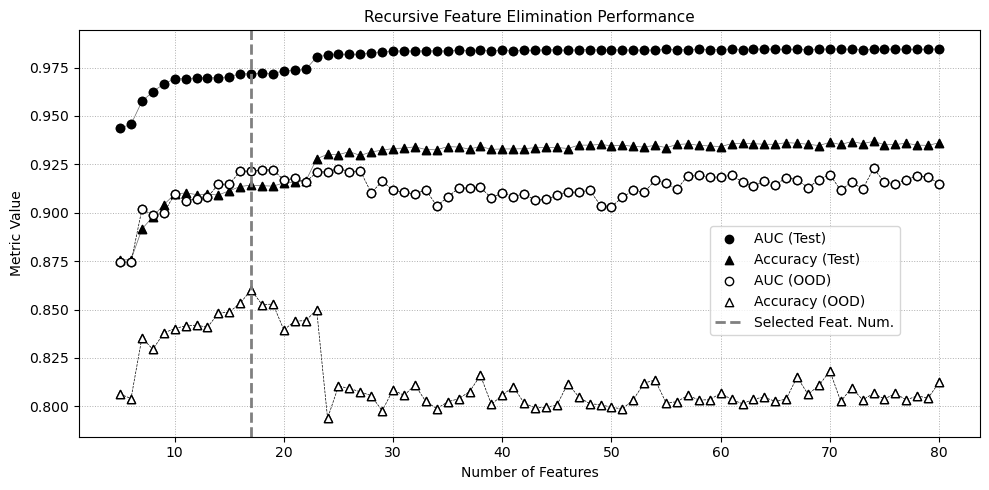

In [156]:
import matplotlib.pyplot as plt


# Each dictionary in 'results' has these columns:
#   'num_features', 'auc_val', 'precision_val', 'accuracy_val',
#   'auc_ood', 'precision_ood', 'accuracy_ood'

# Extract columns for plotting
feature_counts        = results_df_ood['num_features']
auc_test_scores       = results_df_test['auc_test']        # cross_val_ood_metrics calls it 'val' 
precision_test_scores = results_df_test['precision_test']
accuracy_test_scores  = results_df_test['accuracy_test']
auc_ood_scores        = results_df_ood['auc_ood']
precision_ood_scores  = results_df_ood['precision_ood']
accuracy_ood_scores   = results_df_ood['accuracy_ood']

########################################
# 2) Cut the data at 50 features
########################################
lo_cutoff, up_cutoff = 5, 80
mask = (feature_counts <= up_cutoff) & (lo_cutoff <= feature_counts)

feature_counts_cut   = feature_counts[mask]
auc_test_cut         = auc_test_scores[mask]
precision_test_cut   = precision_test_scores[mask]
accuracy_test_cut    = accuracy_test_scores[mask]
auc_ood_cut          = auc_ood_scores[mask]
precision_ood_cut    = precision_ood_scores[mask]
accuracy_ood_cut     = accuracy_ood_scores[mask]

########################################
# 3) Create the plot
########################################

plt.figure(figsize=(10, 5))

# Plot AUC
plt.plot(feature_counts_cut, auc_test_cut,
         color='dimgray', linestyle='-', marker='o', fillstyle='full',linewidth=0.5,
         label=None, zorder=1)   # or "Val" if you prefer
plt.scatter(feature_counts_cut, auc_test_cut,
         color='dimgray',  marker='o', facecolors='black',edgecolors='black',
         label='AUC (Test)',  zorder=2)

# Plot Precision
# plt.plot(feature_counts_cut, precision_test_cut,
#          color='dimgray', linestyle='-', marker='^', fillstyle='full',linewidth=0.5,
#          label=None, zorder=1)
# plt.scatter(feature_counts_cut, precision_test_cut,
#          color='dimgray',  marker='^', facecolors='black',edgecolors='black',
#          label='Precision (Test)',  zorder=2)
# plt.plot(feature_counts_cut, precision_ood_cut,
#          color='black', linestyle='--', linewidth=0.5,fillstyle='none',marker='^',
#          label=None,  zorder=1)
# plt.scatter(feature_counts_cut, precision_ood_cut,
#          color='white',  marker='^', facecolors='white',edgecolors='black',
#          label='Precision (OOD)',  zorder=2)

# Plot Accuracy
plt.plot(feature_counts_cut, accuracy_test_cut,
         color='dimgray', linestyle='-', marker='^', fillstyle='full',linewidth=0.5,
         label=None, zorder=1)
plt.scatter(feature_counts_cut, accuracy_test_cut,
         color='dimgray',  marker='^', facecolors='black',edgecolors='black',
         label='Accuracy (Test)',  zorder=2)


plt.plot(feature_counts_cut, auc_ood_cut,
         color='black', linestyle='--', fillstyle='none',linewidth=0.5,marker='o',
         label=None,  zorder=1)
plt.scatter(feature_counts_cut, auc_ood_cut,
         color='white',  marker='o', facecolors='white',edgecolors='black',
         label='AUC (OOD)',  zorder=2)

plt.plot(feature_counts_cut, accuracy_ood_cut,
         color='black', linestyle='--', linewidth=0.5, fillstyle='none',marker='^',
         label=None, zorder=1)
plt.scatter(feature_counts_cut, accuracy_ood_cut,
         color='white',  marker='^', facecolors='white',edgecolors='black',
         label='Accuracy (OOD)',  zorder=2)
plt.axvline(17, color='gray', linestyle='--', linewidth=2, label='Selected Feat. Num.')

# Format
plt.xlabel('Number of Features', fontsize=10)
plt.ylabel('Metric Value', fontsize=10)
plt.title('Recursive Feature Elimination Performance', fontsize=11)
plt.grid(True, which='both', linestyle=':', linewidth=0.7)
plt.legend(loc=(0.70, 0.25), fontsize=10)


plt.tight_layout()
plt.savefig("rec_feat_elim.pdf", dpi=300, bbox_inches='tight')
plt.savefig("rec_feat_elim.png", dpi=300, bbox_inches='tight')
plt.show()

## Final evaluation of best model under selected features

In [137]:
selected_features = sorted_features[:15]
list(selected_features)

['psd-kurtosis',
 'env-margin-factor',
 'env_freq-avg',
 'env-impulse-factor',
 'env-peak',
 'env-variance',
 '1-peak-prominence-factor',
 'env-psd-entropy',
 'psd-entropy',
 '3-peak-prominence-factor',
 'psd-skew',
 'env-median',
 'env-clearance-factor',
 'env-rms',
 'freq-skew']

In [136]:
# Subset the train and test data to only the selected features
X_train_subset = X_train_scaled[selected_features]
X_test_subset = X_test_scaled[selected_features]

xgb_clf_best = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    gamma=5,
    n_estimators=500,
    subsample=0.75,
    colsample_bytree=0.5,
    min_child_weight=3,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='auc',
    reg_lambda=10
)

# Fit the classifier on the subset of features
xgb_clf_best.fit(X_train_subset, y_train, eval_set=[(X_test_subset, y_test)], verbose=False)

eval_test_dataset(xgb_clf_best, X_test_subset, y_test, 'XGBoost', 'test')
eval_ood_dataset(xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=4,
    gamma=5,
    n_estimators=500,
    subsample=0.75,
    colsample_bytree=0.5,
    min_child_weight=3,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    eval_metric='auc',
    reg_lambda=10
), data_ood_scaled, 'xgb')


=== XGBoost Performance (test Set) ===
Accuracy: 0.9339591747625805
AUC: 0.984291441309287

Confusion Matrix:
 [[3673  228]
 [ 377 4883]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      3901
           1       0.96      0.93      0.94      5260

    accuracy                           0.93      9161
   macro avg       0.93      0.93      0.93      9161
weighted avg       0.93      0.93      0.93      9161

------------------------------------------------------------
=== xgb Performance (OOD Set) ===
Accuracy: 0.8094383613052581
AUC: 0.9186507760277314

Precision (Class 0): 0.7394638574582983
Precision (Class 1): 0.9252202662176268
Recall (Class 0): 0.9058195351331579
Recall (Class 1): 0.6540680158445594
F1-score (Class 0): 0.803532024768401
F1-score (Class 1): 0.6824819595953081
------------------------------------------------------------
